Source: https://aschinchon.wordpress.com/2014/10/13/beautiful-curves-the-harmonograph/

In [127]:
import re
import pandas as pd

import numpy as np
import math
import serial
import pygame
import time
from pygame.locals import QUIT

import matplotlib.pyplot as plt

import shapes

%matplotlib inline

In [128]:
def xt(t):
    return np.exp(-d1*t)*np.sin(t*f1+p1)+np.exp(-d2*t)*np.sin(t*f2+p2)

def yt(t):
    return np.exp(-d3*t)*np.sin(t*f3+p3)+np.exp(-d4*t)*np.sin(t*f4+p4)

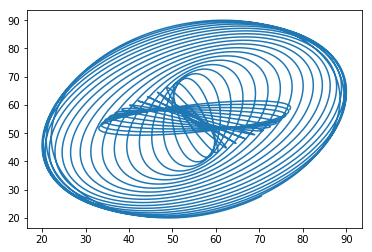

In [211]:
f1, f2, f3, f4 = np.random.randint(2, 4, size=4) + (np.random.random(size=4)-0.5) / 10

d1, d2, d3, d4 = np.random.uniform(0, 1e-02, 4)

p1, p2, p3, p4 = np.random.uniform(0, np.pi, 4)

t = np.linspace(1, 100, num = 10**4)


xs = xt(t)
ys = yt(t)

xs = (xs - min(xs))
ys = (ys - min(ys))

xs = xs * 70 / max(xs) + 20
ys = ys * 70 / max(ys) + 20

plt.plot(xs, ys)


In [212]:
pts = [shapes.Point(xs[0], ys[0])] + [shapes.Line(shapes.Point(xs[i], ys[i]), shapes.Point(xs[i+1], ys[i+1])) for i in range(len(xs)-1)]

In [213]:
def preview_objs(objs):
    pygame.init()

    canvas=pygame.display.set_mode((240,170),0,32)

    white = (255, 255, 255)
    black = (0, 0, 0)

    canvas.fill(white)

    for obj in objs:
        obj.draw(canvas, black)

    while True:
        for event in pygame.event.get():
            if event.type==QUIT:
                pygame.quit()
                return
        pygame.display.update()

def wake_up_serial(port, baud):
    # Open grbl serial port
    s = serial.Serial(port, baud)

    # Wake up grbl
    s.write(b"\r\n\r\n")
    time.sleep(3)   # Wait for grbl to initialize 
    s.flushInput()  # Flush startup text in serial input

    s.write(b"G21\n")   # units = mm
    print(s.readline().strip())
    s.write(b"F10000\n") # feed rate
    print(s.readline().strip())

    s.write(b"S0 M3\n") # pen slightly down
    print(s.readline().strip())

    s.write(b"S0 M5\n") # pen up
    print(s.readline().strip())
    
    return s

def objs_to_plotter(objs, s):
    # display objects and ask for confirmation
    preview_objs(objs)
    r = input("plot this? [y/N]")
    if r != "y":
        return
    
    # if response was 'y', plot it
    for obj in objs:
        for line in obj.plot_instructions():
            l = line + "\n"
            print('Sending: ' + l,)
            s.write(l.encode('utf-8')) # Send g-code block to grbl
            grbl_out = s.readline() # Wait for grbl response with carriage return
            print(grbl_out.strip())

In [214]:
s = wake_up_serial('/dev/tty.wchusbserial1410', 115200)

b'ok'
b'ok'
b'ok'
b'ok'


In [216]:
objs_to_plotter(pts, s)

KeyboardInterrupt: 

In [217]:
s.write(b"S0 M5\n") # pen up
print(s.readline())

s.write(b"G00 X0 Y0\n") # go home
print(s.readline())

time.sleep(3)   # wait for everything to finish 

# close serial port
s.close()

b'ok\r\n'
b'ok\r\n'
